# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall23/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2023-10-08 15:13:21--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py.1’

cifar.py.1          100%[===================>]   2.34K  --.-KB/s    in 0s      

2023-10-08 15:13:21 (49.1 MB/s) - ‘cifar.py.1’ saved [2396/2396]



In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


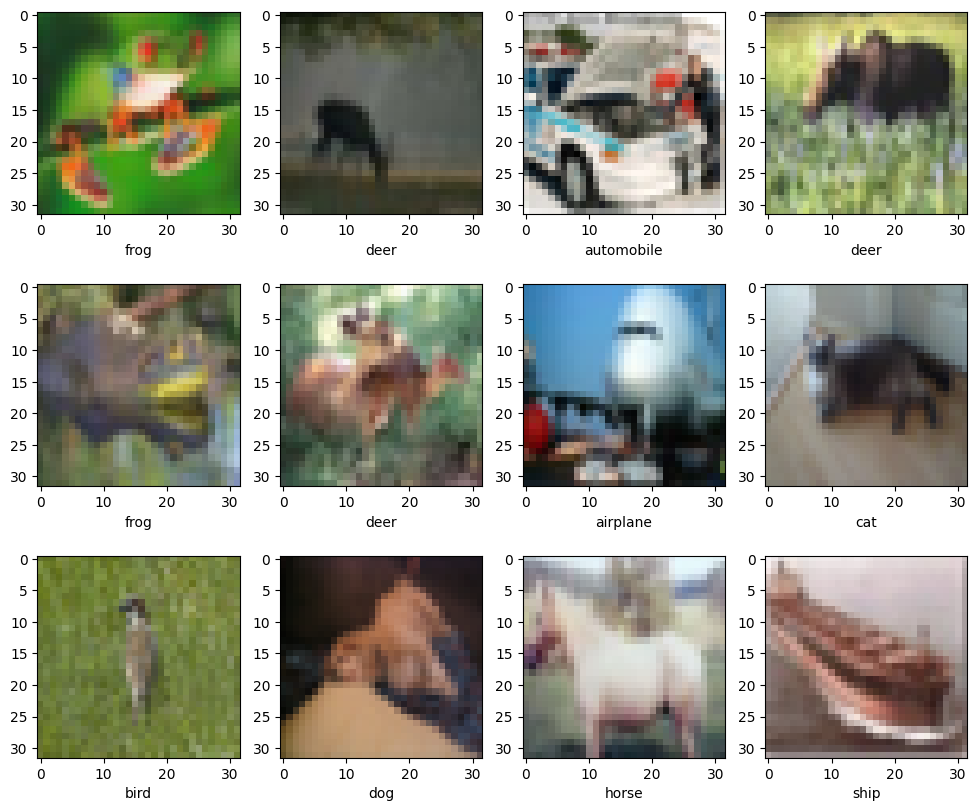

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2498, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 1.344s
  training loss (in-iteration): 	2.050814
  validation accuracy: 			32.30 %
Epoch 2 of 100 took 1.450s
  training loss (in-iteration): 	1.874549
  validation accuracy: 			34.67 %
Epoch 3 of 100 took 1.952s
  training loss (in-iteration): 	1.806393
  validation accuracy: 			37.75 %
Epoch 4 of 100 took 1.377s
  training loss (in-iteration): 	1.757724
  validation accuracy: 			38.68 %
Epoch 5 of 100 took 1.498s
  training loss (in-iteration): 	1.718159
  validation accuracy: 			40.11 %
Epoch 6 of 100 took 1.333s
  training loss (in-iteration): 	1.684163
  validation accuracy: 			40.88 %
Epoch 7 of 100 took 1.332s
  training loss (in-iteration): 	1.657084
  validation accuracy: 			42.20 %
Epoch 8 of 100 took 1.324s
  training loss (in-iteration): 	1.629577
  validation accuracy: 			41.20 %
Epoch 9 of 100 took 1.294s
  training loss (in-iteration): 	1.611863
  validation accuracy: 			43.11 %
Epoch 10 of 100 took 1.313s
  training loss (in-iteration): 	1.593599
  v

KeyboardInterrupt: ignored

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		48.35 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [ ]:
import torch.optim as optim
class SmallConvNet(nn.Module):
    def __init__(self):
        super(SmallConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)  # Convolution layer
        self.pool1 = nn.MaxPool2d(2)  # Max pooling 2x2
        self.fc1 = nn.Linear(10 * 15 * 15, 100)  # Fully connected layer
        self.fc2 = nn.Linear(100, 10)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = x.view(-1, 10 * 15 * 15)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1, training=self.training)  # 10% dropout during training
        x = self.fc2(x)
        return x

# Create the model and set up optimizer
model = SmallConvNet()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Training loop
num_epochs = 100
batch_size = 50

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # Training
    model.train(True)  # Enable dropout during training
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        optimizer.zero_grad()
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.train(False)  # Disable dropout during validation
    correct = 0
    total = 0
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        """y_pred = logits.max(1)[1].data.numpy()
        correct += (y_pred == y_batch).float().mean().item()
        total += y_batch.size(0)"""
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))
    #val_accuracy.append(correct / total)

    # Print progress
    """print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {np.mean(train_loss[-len(X_train) // batch_size :]):.4f}, "
          f"Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")"""

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))



Epoch 1 of 100 took 17.394s
  training loss (in-iteration): 	1.805449
  validation accuracy: 			44.03 %
Epoch 2 of 100 took 27.834s
  training loss (in-iteration): 	1.525908
  validation accuracy: 			48.51 %
Epoch 3 of 100 took 37.552s
  training loss (in-iteration): 	1.428069
  validation accuracy: 			50.84 %
Epoch 4 of 100 took 47.924s
  training loss (in-iteration): 	1.358225
  validation accuracy: 			53.36 %
Epoch 5 of 100 took 58.371s
  training loss (in-iteration): 	1.291708
  validation accuracy: 			52.71 %
Epoch 6 of 100 took 68.702s
  training loss (in-iteration): 	1.235428
  validation accuracy: 			56.06 %
Epoch 7 of 100 took 78.999s
  training loss (in-iteration): 	1.192255
  validation accuracy: 			58.01 %
Epoch 8 of 100 took 89.434s
  training loss (in-iteration): 	1.151101
  validation accuracy: 			58.45 %
Epoch 9 of 100 took 98.950s
  training loss (in-iteration): 	1.121803
  validation accuracy: 			59.04 %
Epoch 10 of 100 took 109.219s
  training loss (in-iteration): 	1

KeyboardInterrupt: ignored

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		60.05 %
Achievement unlocked: 70lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [ ]:
class SmallConvNetWithBN(nn.Module):
    def __init__(self):
        super(SmallConvNetWithBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2)
        self.flat_size = 10 * 15 * 15
        self.fc1 = nn.Linear(self.flat_size, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = x.view(-1, self.flat_size)  # flatten
        x = self.fc1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the new model
model = SmallConvNetWithBN()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters())




In [ ]:
# Training loop
num_epochs = 100
batch_size = 50

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # Training
    model.train(True)  # Enable dropout during training
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        optimizer.zero_grad()
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.train(False)  # Disable dropout during validation
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        """y_pred = logits.max(1)[1].data.numpy()
        correct += (y_pred == y_batch).float().mean().item()
        total += y_batch.size(0)"""
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))
    #val_accuracy.append(correct / total)

    # Print progress
    """print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {np.mean(train_loss[-len(X_train) // batch_size :]):.4f}, "
          f"Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")"""

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 171.573s
  training loss (in-iteration): 	1.408497
  validation accuracy: 			50.01 %
Epoch 2 of 100 took 182.228s
  training loss (in-iteration): 	1.145896
  validation accuracy: 			56.92 %
Epoch 3 of 100 took 192.759s
  training loss (in-iteration): 	1.019129
  validation accuracy: 			59.66 %
Epoch 4 of 100 took 203.251s
  training loss (in-iteration): 	0.934595
  validation accuracy: 			55.42 %
Epoch 5 of 100 took 213.758s
  training loss (in-iteration): 	0.857269
  validation accuracy: 			62.24 %
Epoch 6 of 100 took 224.044s
  training loss (in-iteration): 	0.789911
  validation accuracy: 			62.17 %
Epoch 7 of 100 took 233.841s
  training loss (in-iteration): 	0.728371
  validation accuracy: 			62.31 %
Epoch 8 of 100 took 244.324s
  training loss (in-iteration): 	0.678526
  validation accuracy: 			55.41 %
Epoch 9 of 100 took 254.789s
  training loss (in-iteration): 	0.626810
  validation accuracy: 			62.33 %
Epoch 10 of 100 took 265.239s
  training loss (in-itera

KeyboardInterrupt: ignored

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		60.82 %
Achievement unlocked: 70lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [ ]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

In [ ]:
"""
for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)

    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )


    raise NotImplementedError("Plese use this code in your training loop")"""
    # TODO use this in your training loop

'\nfor (x_batch, y_batch) in train_batch_gen:\n\n    print(\'X:\', type(x_batch), x_batch.shape)\n    print(\'y:\', type(y_batch), y_batch.shape)\n\n    for i, img in enumerate(x_batch.numpy()[:8]):\n        plt.subplot(2, 4, i+1)\n        plt.imshow(img.transpose([1,2,0]) * stds + means )\n\n\n    raise NotImplementedError("Plese use this code in your training loop")'

When testing, we don't need random crops, just normalize with same statistics.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])


val_dataset = CIFAR10("./cifar_data/", train=False, transform=transform_augment)
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=32,
                                            shuffle=False,
                                            num_workers=1)





In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SmallConvNetWithBN().to(device)
optimizer = torch.optim.Adam(model.parameters())


X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


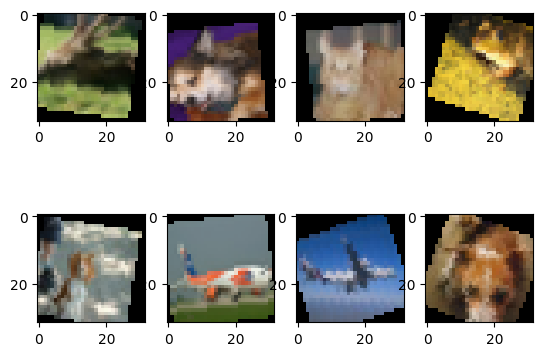

Epoch 1 of 100 took 1366.797s
  training loss (in-iteration): 	1.295420
  validation accuracy: 			56.68 %
Epoch 2 of 100 took 1405.127s
  training loss (in-iteration): 	1.294710
  validation accuracy: 			55.46 %
Epoch 3 of 100 took 1443.240s
  training loss (in-iteration): 	1.285240
  validation accuracy: 			56.95 %
Epoch 4 of 100 took 1481.137s
  training loss (in-iteration): 	1.282647
  validation accuracy: 			57.77 %
Epoch 5 of 100 took 1519.172s
  training loss (in-iteration): 	1.274905
  validation accuracy: 			57.57 %
Epoch 6 of 100 took 1556.496s
  training loss (in-iteration): 	1.270544
  validation accuracy: 			57.82 %
Epoch 7 of 100 took 1593.458s
  training loss (in-iteration): 	1.268539
  validation accuracy: 			57.77 %
Epoch 8 of 100 took 1630.726s
  training loss (in-iteration): 	1.268053
  validation accuracy: 			57.98 %
Epoch 9 of 100 took 1667.954s
  training loss (in-iteration): 	1.254414
  validation accuracy: 			58.10 %
Epoch 10 of 100 took 1705.337s
  training loss

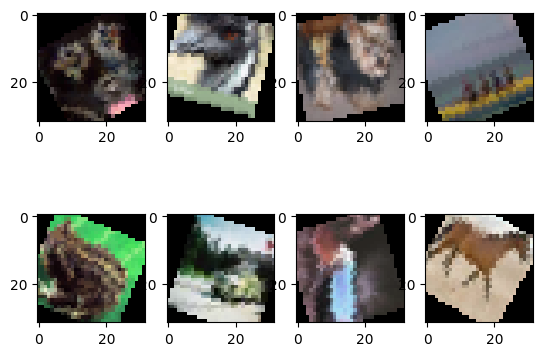

Epoch 11 of 100 took 1743.367s
  training loss (in-iteration): 	1.249937
  validation accuracy: 			58.84 %
Epoch 12 of 100 took 1780.577s
  training loss (in-iteration): 	1.248491
  validation accuracy: 			59.27 %
Epoch 13 of 100 took 1817.868s
  training loss (in-iteration): 	1.248636
  validation accuracy: 			58.08 %
Epoch 14 of 100 took 1855.218s
  training loss (in-iteration): 	1.246684
  validation accuracy: 			58.85 %
Epoch 15 of 100 took 1893.048s
  training loss (in-iteration): 	1.241546
  validation accuracy: 			58.44 %
Epoch 16 of 100 took 1930.459s
  training loss (in-iteration): 	1.239623
  validation accuracy: 			59.14 %
Epoch 17 of 100 took 1967.718s
  training loss (in-iteration): 	1.233936
  validation accuracy: 			58.87 %
Epoch 18 of 100 took 2004.882s
  training loss (in-iteration): 	1.233368
  validation accuracy: 			58.58 %
Epoch 19 of 100 took 2042.425s
  training loss (in-iteration): 	1.230455
  validation accuracy: 			59.01 %
Epoch 20 of 100 took 2079.770s
  trai

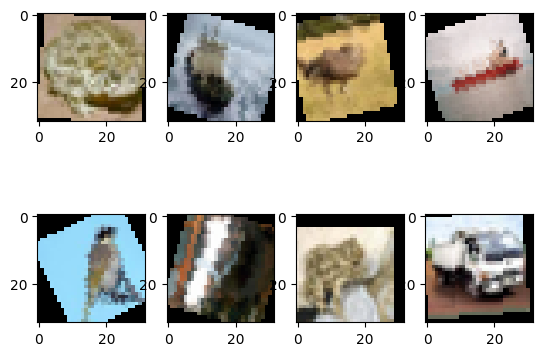

Epoch 21 of 100 took 2117.839s
  training loss (in-iteration): 	1.226225
  validation accuracy: 			59.04 %
Epoch 22 of 100 took 2154.707s
  training loss (in-iteration): 	1.224937
  validation accuracy: 			59.75 %


KeyboardInterrupt: ignored

In [ ]:
num_epochs = 100
batch_size = 32
train_loss = []
val_accuracy = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for epoch in range(num_epochs):
    # Training

    model.train(True)  # Enable dropout and batch normalization during training

    for batch_idx, (X_batch, y_batch) in enumerate(train_batch_gen):

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU

        # Visualize the first batch of every epoch, just for checking augmentation
        if batch_idx == 0 and epoch % 10 == 0:  # every 10 epochs
            print('X:', type(X_batch), X_batch.shape)
            print('y:', type(y_batch), y_batch.shape)

            for i, img in enumerate(X_batch.cpu().numpy()[:8]):  # move tensor to cpu before converting to numpy
                plt.subplot(2, 4, i+1)
                plt.imshow(np.clip(img.transpose([1,2,0]) * stds + means, 0, 1))
            plt.show()

        optimizer.zero_grad()
        loss = compute_loss(X_batch, y_batch.to(device))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.train(False)
    for X_batch, y_batch in val_batch_gen:
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        """logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))"""
        X_batch = X_batch.to(device)
        #logits = model(X_batch)

        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].detach().cpu().numpy()
        y_batch = y_batch.detach().cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    """print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {np.mean(train_loss[-len(train_loader) // 32:]):.4f}, "
          f"Validation Accuracy: {np.mean(val_accuracy[-len(test_loader) // 32:]) * 100:.2f}%")"""
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // 32 :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // 32 :]) * 100))

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])


test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=32,
                                            shuffle=False,
                                            num_workers=1)

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    X_batch = X_batch.to(device)
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    y_batch = y_batch.detach().cpu().numpy()
    #y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		59.81 %
Achievement unlocked: 60lvl Warlock!


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


In [ ]:
# you might as well write your solution here :)

##Model PipeLine:

Since we already achieved 60%, so we try to expand it, by having the CNN as followes:

Input Layer (nn.Conv2d):

Input Shape: 3 channels (RGB images)
Output Shape: 64 channels
Kernel Size: 3x3
Padding: 1 (to maintain spatial dimensions)
Activation Function: ReLU (Rectified Linear Unit)
Batch Normalization (nn.BatchNorm2d):

Normalizes the activations of the previous convolutional layer.
ReLU Activation Function (nn.ReLU):

Applies the Rectified Linear Unit (ReLU) activation function element-wise.
Convolutional Layer (nn.Conv2d):

Input Shape: 64 channels
Output Shape: 64 channels
Kernel Size: 3x3
Padding: 1
Activation Function: ReLU
Batch Normalization (nn.BatchNorm2d):

Normalizes the activations of the previous convolutional layer.
ReLU Activation Function (nn.ReLU):

Applies the ReLU activation function element-wise.
Max Pooling Layer (nn.MaxPool2d):

Performs 2x2 max pooling with a stride of 2.
Reduces spatial dimensions by half (e.g., from 32x32 to 16x16).
Flatten Layer (Flatten()):

Flattens the output from the previous layers to a 1D tensor.
The output shape after flattening is 64 x 16 x 16.
Fully Connected Layer (nn.Linear):

Input Features: 64 * 16 * 16
Output Features: 512
Activation Function: ReLU
Batch Normalization (nn.BatchNorm1d):

Normalizes the activations of the fully connected layer.
ReLU Activation Function (nn.ReLU):

Applies the ReLU activation function element-wise.
Dropout Layer (nn.Dropout):

Applies dropout with a probability of 0.1 (10% dropout) to prevent overfitting during training.
Fully Connected Layer (nn.Linear):

Input Features: 512
Output Features: 10 (assuming this is a classification task with 10 classes)
Final Output:

The final fully connected layer provides the model's output, which represents class probabilities for the 10 possible classes (e.g., in CIFAR-10).
To Device (to(device)):

Moves the entire model to the specified device (CPU or GPU) for computation.

##Fianlly at the End we have ResNet and DenseNet implemented along with saliency maps for the ResNet.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

"""
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

        # Dropout layer
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x"""




import torchvision.transforms as transforms
import torchvision.datasets as datasets



batch_size=128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    Flatten(),
    nn.Linear(64 * 16 * 16, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, 10)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


100%|██████████| 170498071/170498071 [00:03<00:00, 44828857.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_loss = []
val_accuracy = []
num_epochs = 200
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    # Validation
    model.train(False)
    for X_batch, y_batch in val_loader:
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        """logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))"""
        X_batch = X_batch.to(device)
        #logits = model(X_batch)

        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].detach().cpu().numpy()
        y_batch = y_batch.detach().cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    """print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {np.mean(train_loss[-len(train_loader) // 32:]):.4f}, "
          f"Validation Accuracy: {np.mean(val_accuracy[-len(test_loader) // 32:]) * 100:.2f}%")"""
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_loader) // batch_size :]) * 100))

    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch 1 of 200 took 2305.227s
  training loss (in-iteration): 	1.154848
  validation accuracy: 			43.75 %
Epoch 2 of 200 took 2328.655s
  training loss (in-iteration): 	0.905974
  validation accuracy: 			56.25 %
Epoch 3 of 200 took 2352.668s
  training loss (in-iteration): 	0.873917
  validation accuracy: 			62.50 %
Epoch 4 of 200 took 2376.318s
  training loss (in-iteration): 	0.737812
  validation accuracy: 			68.75 %
Epoch 5 of 200 took 2400.235s
  training loss (in-iteration): 	0.765296
  validation accuracy: 			68.75 %
Epoch 6 of 200 took 2422.895s
  training loss (in-iteration): 	0.755507
  validation accuracy: 			68.75 %
Epoch 7 of 200 took 2446.522s
  training loss (in-iteration): 	0.763145
  validation accuracy: 			75.00 %
Epoch 8 of 200 took 2470.706s
  training loss (in-iteration): 	0.666527
  validation accuracy: 			75.00 %
Epoch 9 of 200 took 2494.293s
  training loss (in-iteration): 	0.697291
  validation accuracy: 			75.00 %
Epoch 10 of 200 took 2518.008s
  training loss

KeyboardInterrupt: ignored

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


test_loader = datasets.CIFAR10("./data", train=False,download=True, transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=2)

Files already downloaded and verified


In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    X_batch = X_batch.to(device)
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    y_batch = y_batch.detach().cpu().numpy()
    #y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		81.34 %
Achievement unlocked: 110lvl Warlock!


##ResNet

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

resnet = models.resnet18(pretrained=False, num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.8, weight_decay=1e-4)

def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total * 100


num_epochs = 50

for epoch in range(num_epochs):
    resnet.train()
    total_loss = 0
    total_accuracy = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)


        optimizer.zero_grad()


        outputs = resnet(inputs)
        loss = criterion(outputs, targets)


        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy(outputs, targets)

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")


    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_accuracy / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg. Training Loss: {avg_train_loss:.4f}, Avg. Training Accuracy: {avg_train_accuracy:.2f}%")




Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50] Batch [0/391] Loss: 2.4750
Epoch [1/50] Batch [100/391] Loss: 1.6733
Epoch [1/50] Batch [200/391] Loss: 1.6592
Epoch [1/50] Batch [300/391] Loss: 1.5889
Epoch [1/50] Avg. Training Loss: 1.6762, Avg. Training Accuracy: 38.71%
Epoch [2/50] Batch [0/391] Loss: 1.3611
Epoch [2/50] Batch [100/391] Loss: 1.3472
Epoch [2/50] Batch [200/391] Loss: 1.3430
Epoch [2/50] Batch [300/391] Loss: 1.4256
Epoch [2/50] Avg. Training Loss: 1.3540, Avg. Training Accuracy: 50.57%
Epoch [3/50] Batch [0/391] Loss: 1.2992
Epoch [3/50] Batch [100/391] Loss: 1.1039
Epoch [3/50] Batch [200/391] Loss: 1.2197
Epoch [3/50] Batch [300/391] Loss: 1.1450
Epoch [3/50] Avg. Training Loss: 1.1998, Avg. Training Accuracy: 56.63%
Epoch [4/50] Batch [0/391] Loss: 1.1649
Epoch [4/50] Batch [100/391] Loss: 1.0494
Epoch [4/50] Batch [200/391] Loss: 1.1720
Epoch [4/50] Batch [300/391] Loss: 1.1101
Epoch [4/50] Avg. Training Loss: 1.0861, Avg

KeyboardInterrupt: ignored

In [ ]:

resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 78.12%


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00


##Saliency Maps for ResNet


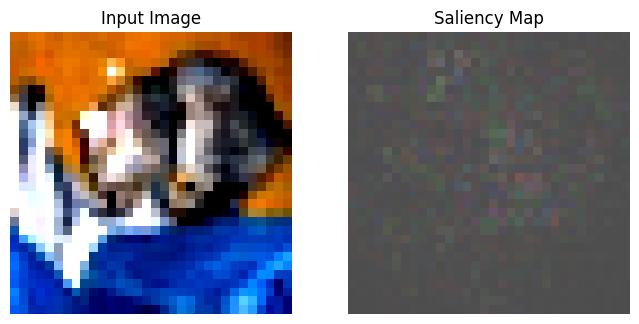

In [ ]:
from captum.attr import Saliency
saliency = Saliency(resnet)

input_image, target_class = next(iter(test_loader))
input_image, target_class = input_image.to(device), target_class.to(device)

saliency_map = saliency.attribute(input_image, target=target_class)


import matplotlib.pyplot as plt

def visualize_saliency_map(input_image, saliency_map):
    # Normalize the saliency map to [0, 1]
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    img = input_image[0].cpu().numpy().transpose((1, 2, 0))
    img = (img * 0.5) + 0.5  # Denormalize
    plt.imshow(img)
    plt.axis('off')
    plt.title('Input Image')
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map[0].cpu().numpy().transpose(1, 2, 0), cmap='hot', alpha=0.7)
    plt.axis('off')
    plt.title('Saliency Map')

    plt.show()


visualize_saliency_map(input_image, saliency_map)

##DenseNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import densenet121
from torch.utils.data import DataLoader


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import densenet121
from torch.utils.data import DataLoader


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


model = densenet121(pretrained=False, num_classes=10)  # 10 classes for CIFAR-10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    train_accuracy = 100 * correct / total
    val_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.2f}% "
          f"Val Loss: {val_loss:.4f} Val Accuracy: {val_accuracy:.2f}%")




Epoch [1/100] Train Loss: 761.2621 Train Accuracy: 38.08% Val Loss: 66.9268 Val Accuracy: 38.08%
Epoch [2/100] Train Loss: 554.4758 Train Accuracy: 45.00% Val Loss: 60.1732 Val Accuracy: 45.00%
Epoch [3/100] Train Loss: 496.6026 Train Accuracy: 51.86% Val Loss: 54.1251 Val Accuracy: 51.86%
Epoch [4/100] Train Loss: 448.4331 Train Accuracy: 55.68% Val Loss: 49.7885 Val Accuracy: 55.68%
Epoch [5/100] Train Loss: 408.6170 Train Accuracy: 59.78% Val Loss: 48.7093 Val Accuracy: 59.78%
Epoch [6/100] Train Loss: 376.2583 Train Accuracy: 60.88% Val Loss: 50.1307 Val Accuracy: 60.88%
Epoch [7/100] Train Loss: 365.4133 Train Accuracy: 64.04% Val Loss: 40.4847 Val Accuracy: 64.04%
Epoch [8/100] Train Loss: 333.7634 Train Accuracy: 66.10% Val Loss: 48.5251 Val Accuracy: 66.10%
Epoch [9/100] Train Loss: 326.7597 Train Accuracy: 66.06% Val Loss: 38.7789 Val Accuracy: 66.06%
Epoch [10/100] Train Loss: 304.0623 Train Accuracy: 62.18% Val Loss: 45.8218 Val Accuracy: 62.18%
Epoch [11/100] Train Loss: 28

KeyboardInterrupt: ignored

In [ ]:

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 52.8524 Test Accuracy: 77.42%
